# Floc Analysis

This page shows an example of doing an analysis of the watercolumn floc using the CamHDHub and Dask. The goal of this work is to understand changes in the concentration of "floc", or bacterial material that has been flushed from the hydrothermal system into the ocean. Changes in floc are an indicator of changes in the hydrothermal system, often as a result of a magmatic event or seismic swarm.

This notebook uses [Dask](http://dask.pydata.org/en/latest/) to analyze a large number of frames to establish a proxy for the floc concentration, then plots this value using a two-dimensional multivariate histogram.

This version of the floc analysis uses a list of remote files to define the video data to be processed. The set of files processed is from CamHD deployment 3.

#### Setup your environment

In [1]:
%matplotlib inline
import pycamhd as camhd
import numpy as np
import matplotlib.pyplot as plt

#### Get a list of local CamHD files to process

In [2]:
filenames = []
with open('d3.txt') as f:
    for line in f:
        filenames.append(line)

#### Define the frame numbers from each file to process

In [3]:
#frame_numbers = [3841,3842,3843,3871,3872,3873,3901,3902,3903,3931,3932,
#                 3933,3961,3962,3963,3991,3992,3993,4021,4022,4023,4051,
#                 4052,4053,4081,4082,4083,4111,4112,4113,4141,4142,4143,
#                 4171,4172,4173,4201,4202,4203,4231,4232,4233,4261,4262,
#                 4263,4291,4292,4293,4321,4322,4323,4351,4352,4353,4381,
#                 4382,4383,4411,4412,4413]

# for testing we just run a single frame
frame_numbers = [3841,3871,3901,3931,3961,3993,4051,4083,4143,4203] 

These frame numbers correspond to times when the camera system is looking over the "shoulder" of Mushroom vent. For each file in filenames, and for each frame in frame_numbers, we will process a 1024x1024 subimage that looks like this:

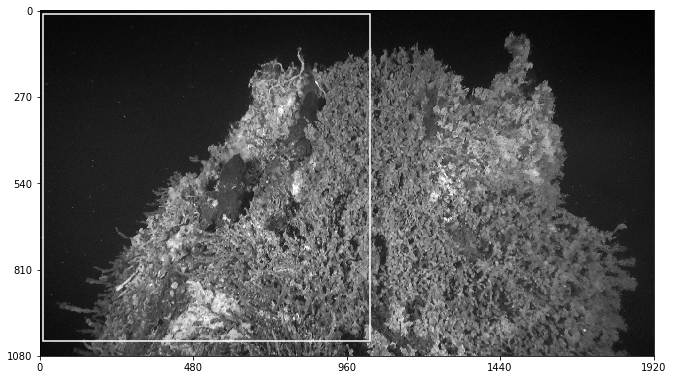

In [4]:
import matplotlib.patches as patches
plt.rc('figure', figsize=(11, 11))
frame = camhd.get_frame(filenames[2], frame_numbers[0], 'gray16le')
fig, ax = plt.subplots();
im1 = ax.imshow(frame);
im1.set_cmap('gray');
plt.yticks(np.arange(0,1081,270))
plt.xticks(np.arange(0,1921,480));

# ROI
rect = patches.Rectangle((10,10),1024,1024,linewidth=1.5,edgecolor='w',facecolor='none');
ax.add_patch(rect);
plt.show();

#### Create the filter for filtering images in the frequency domain
To deal with variations in lighting and high-frequency noise, we filter each subimage using a Butterworth bandpass filter.

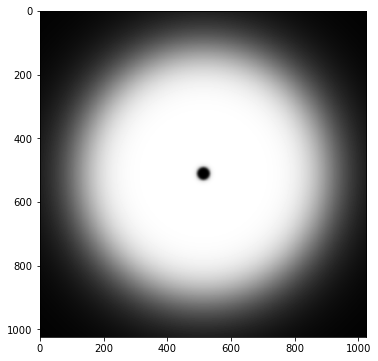

In [5]:
plt.rc('figure', figsize=(6, 6))
d1 = 20; # low cut wavenumber
d2 = 400; # high cut wavenumber
n = 4;
x = np.arange(-1024/2+0.5,1024/2+1-0.5)
xx, yy = np.meshgrid(x, x)
d = np.sqrt(xx**2+yy**2);
bff = (1 - (1./(1 + (d/d1)**(2*n))))*(1/(1 + (d/d2)**(2*n))); # Butterworth bandpass filter
imgplot = plt.imshow(bff, cmap='gray')

#### Setup the Dask delayed functions
The floc proxy is simply the number of pixels in each filtered subimage that have a value greater than 4000.

In [ ]:
from dask.multiprocessing import get
from dask import delayed, compute

@delayed
def delayed_get_frame(filename, frame_number, pix_fmt):
    return camhd.get_frame(filename, frame_number, pix_fmt)

@delayed
def delayed_get_floc_proxy(frame):
    I = frame[0:1024, 0:1024]
    I_fft = np.fft.fft2(I);
    I_fft_shift = np.fft.fftshift(I_fft);
    I_fft_shift_filt = I_fft_shift*bff; # filter with the Butterworth filter
    I_fft_filt = np.fft.ifftshift(I_fft_shift_filt);
    I_filt = np.fft.ifft2(I_fft_filt);
    return (np.absolute(I_filt)>4000).sum()

#### Calculate the floc_proxy using Dask parallelization
We use Dask to handle load balancing among processors on the system.

In [ ]:
%%time
delayed_floc_proxy = []
for filename in filenames:
    for frame_number in frame_numbers:
        frame = delayed_get_frame(filename, frame_number, 'gray16le')
        delayed_floc_proxy.append(delayed_get_floc_proxy(frame))
floc_proxy = compute(*delayed_floc_proxy)

#### Get a timestamp for each frame

In [ ]:
import datetime, math
import matplotlib.dates as dates
frame_timestamp = []
for filename in filenames:
    filename = filename.rsplit('/',1)[1]
    for frame_number in frame_numbers:
        year = int(filename[10:14])
        month = int(filename[14:16])
        day = int(filename[16:18])
        hour = int(filename[19:21])
        minute = int(math.floor(frame_number/29.95/60))
        second = int(math.floor(frame_number/29.95-minute*60))
        microsecond = int(round((frame_number/29.95-second-minute*60)*1000000))
        dt = datetime.datetime(year, month, day, hour, minute, second, microsecond)
        frame_timestamp.append(dates.date2num(dt))

#### Plot a two-dimensional multivariate histogram of the results

In [ ]:
plt.rc('font', size=11)
fig, ax = plt.subplots();
fig.set_size_inches(14, 6);
fig.frameon = False
hb1 = ax.hexbin(frame_timestamp, floc_proxy, vmin=0, vmax=1, bins='log', linewidths=0.25,
  gridsize=(225,4500), mincnt=1, cmap=plt.cm.BuPu)
fig.colorbar(hb1)
ax.set_ylim([0, 8000])
ax.set_xlim([frame_timestamp[0],frame_timestamp[-1]])
ax.yaxis.grid(True)
ax.xaxis.grid(True)
months = dates.MonthLocator()  # every month
monthsFmt = dates.DateFormatter('%b %Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
plt.ylabel('Floc Proxy Value');

# print
#fig_dpi = 300
#fig.savefig('floc_hexbin.png', bbox_inches='tight', transparent=True,
#  pad_inches=0, orientation='portrait', format='png', dpi=fig_dpi);

### References

PyCamHD: https://github.com/tjcrone/pycamhd<br>
CamHDHub: https://github.com/tjcrone/camhdhub<br>
Raw Data Archive: https://rawdata.oceanobservatories.org/files/RS03ASHS/PN03B/06-CAMHDA301/<br>
AGU Abstract: https://agu.confex.com/agu/fm16/meetingapp.cgi/Paper/192670<br>
AGU Poster: https://drive.google.com/open?id=0B-dWW4GM434obGpTM0FZME10Nkk<br>
Dask: http://dask.pydata.org/en/latest/